In [66]:
import pandas as pd
import numpy as np

# Создание датасета

In [67]:
grades = ['Отлично','Хорошо','Удовлетворительно']
n = 2500
df = pd.DataFrame({
   'anatomy':[np.random.randint(0,99) for _ in range(n)],
   'histology':[np.random.randint(0,99) for _ in range(n)],
   'med_biology':[np.random.randint(0,99) for _ in range(n)],
   'chemistry':[np.random.randint(0,99) for _ in range(n)],
   'physics':[np.random.randint(0,99) for _ in range(n)],
   'latin':[np.random.randint(0,99) for _ in range(n)],
   'solution time, min':[np.random.randint(30,90) for _ in range(n)],
   'grade':[np.random.choice(grades) for _ in range(n)]
    })
df.head()

,anatomy,histology,med_biology,chemistry,physics,latin,"solution time, min",grade
0,51,5,71,2,1,30,68,Отлично
1,7,91,2,41,42,69,43,Удовлетворительно
2,62,47,81,26,33,42,56,Удовлетворительно
3,44,63,63,37,6,19,84,Удовлетворительно
4,54,28,73,60,53,80,83,Удовлетворительно


# Преобразуем категориальные данные в числовые (для целевой переменной)

In [68]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['grade'])
df['grade'] = le.transform(df['grade'])
df.head()

,anatomy,histology,med_biology,chemistry,physics,latin,"solution time, min",grade
0,51,5,71,2,1,30,68,0
1,7,91,2,41,42,69,43,1
2,62,47,81,26,33,42,56,1
3,44,63,63,37,6,19,84,1
4,54,28,73,60,53,80,83,1


# Разбиение выборки на обучающую и тестовую

In [69]:
from sklearn.model_selection import train_test_split
X = df.drop('grade', axis=1)
y = df['grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=53)

# Вычисление значимости признаков с помощью случайного леса

Точность полученной модели составляет 1.0


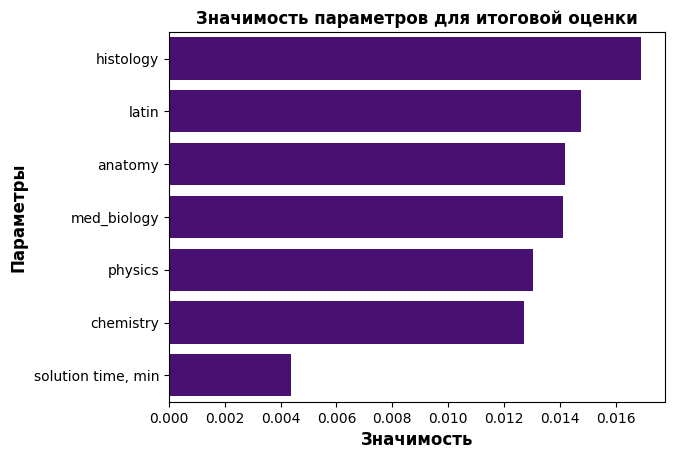

,Параметры,Gini-Importance
0,histology,0.146904
1,latin,0.144742
2,anatomy,0.144164
3,med_biology,0.144096
4,physics,0.143024
5,chemistry,0.142703
6,"solution time, min",0.134367


In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import seaborn as sns

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
accuracy = rfc.score(X_train, y_train)
print(f'Точность полученной модели составляет {accuracy}')

rfc.feature_importances_
feats = {}
for feature, importance in list(zip(X_train.columns, rfc.feature_importances_)):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Параметры'})
fig, ax = plt.subplots()
sns.barplot(x=importances['Gini-Importance']-0.13, y=importances['Параметры'], data=importances, color='indigo')
plt.xlabel('Значимость', fontsize=12, weight = 'bold')
plt.ylabel('Параметры', fontsize=12, weight = 'bold')
plt.title('Значимость параметров для итоговой оценки', fontsize=12, weight = 'bold')
plt.show()
display(importances)

# Разделение данных на обучающие и тестовые выборки и обучение модели
(используем другую модель GradientBoosting, чтобы попробовать)

Используем только наиболее значимые признаки (при запуске у меня были):

*   histology
*   latin
*   anatomy





In [80]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import pickle as pkl

X = df.drop('grade', axis=1)
y = df['grade']
X_train, X_test, y_train, y_test = train_test_split(X[['anatomy','latin','histology']], y, test_size=0.2, random_state=53)

model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0).fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print(f'Точность полученной модели составляет {accuracy}')

pkl_filename = "model.pkl"
with open(pkl_filename, 'wb') as file:
  pkl.dump(model, file)

Точность полученной модели составляет 0.334


# Тестирование модели

In [81]:
from sklearn.metrics import accuracy_score

with open(pkl_filename, 'rb') as file:
 model = pkl.load(file)
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f'Точность полученной модели составляет {score}')

Точность полученной модели составляет 0.334


# Функция предсказания итоговой оценки по переданным признакам
*   histology
*   latin
*   anatomy

In [88]:

class student_data:
    def __init__(self, histology, latin, anatomy):
        self.anatomy = anatomy
        self.latin = latin
        self.histology = histology

def predictGrade(student, pkl_filename="model.pkl"):
    # Чтение обученной модели из файла
    model = GradientBoostingClassifier()
    with open(pkl_filename, 'rb') as file:
      model = pkl.load(file)

    new_data = pd.DataFrame([student.__dict__])
    predicted_grade = model.predict(new_data)[0]

    # Преобразование в текстовую категорию
    grades = ['Отлично','Удовлетворительно','Хорошо']
    predicted_grade = grades[predicted_grade]

    return predicted_grade

# Пример вызова функции, которая по заданной модели и оценкам выдает предсказание по итоговой оценке

In [94]:
st1 = student_data(histology=85, latin=50, anatomy=47)
grade = predictGrade(st1)
print(f'Возможная оценка: {grade}')

Возможная оценка: Удовлетворительно
